# Codeword Length = 31, T(seq len)=10, p belongs to {0.001, 0.005, 0.01, 0.05}

In [1]:
# changepoint_detection_updated.py
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
print(os.listdir("/kaggle/input/bsc-bch-codeword-length31"))

['bsc_p0.010_codewords2.csv', 'bsc_p0.005_codewords1.csv', 'bsc_p0.050_codewords2.csv', 'bsc_p0.010_codewords1.csv', 'bsc_p0.001_codewords1.csv', 'bsc_p0.050_codewords1.csv', 'bsc_p0.001_codewords2.csv', 'bsc_p0.005_codewords2.csv']


In [5]:
pd.read_csv("/kaggle/input/bsc-bch-codeword-length31/bsc_p0.001_codewords1.csv").shape[1]

31

## p = 0.001 

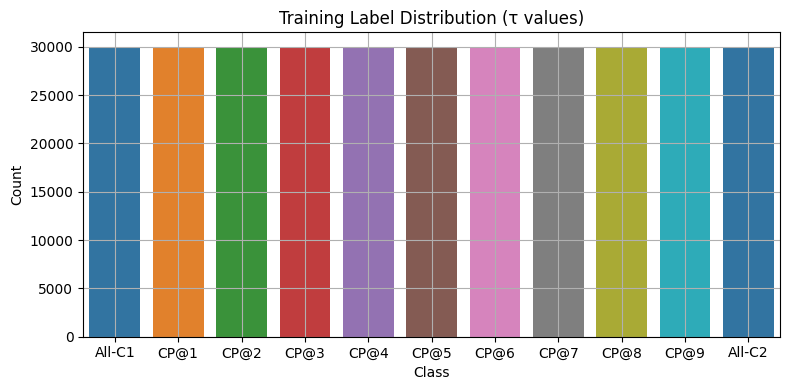

Training Epochs:   2%|▏         | 1/50 [00:30<25:03, 30.68s/it]

Epoch  1 | Train Loss: 2.3900 | Val Accuracy: 0.1963


Training Epochs:   4%|▍         | 2/50 [01:01<24:28, 30.59s/it]

Epoch  2 | Train Loss: 1.1321 | Val Accuracy: 0.8324


Training Epochs:   6%|▌         | 3/50 [01:31<24:00, 30.65s/it]

Epoch  3 | Train Loss: 0.5820 | Val Accuracy: 0.9282


Training Epochs:   8%|▊         | 4/50 [02:02<23:29, 30.63s/it]

Epoch  4 | Train Loss: 0.3951 | Val Accuracy: 0.9484


Training Epochs:  10%|█         | 5/50 [02:33<23:11, 30.92s/it]

Epoch  5 | Train Loss: 0.3265 | Val Accuracy: 0.9555


Training Epochs:  12%|█▏        | 6/50 [03:04<22:32, 30.74s/it]

Epoch  6 | Train Loss: 0.2921 | Val Accuracy: 0.9603


Training Epochs:  14%|█▍        | 7/50 [03:35<22:01, 30.73s/it]

Epoch  7 | Train Loss: 0.2691 | Val Accuracy: 0.9643


Training Epochs:  16%|█▌        | 8/50 [04:05<21:30, 30.73s/it]

Epoch  8 | Train Loss: 0.2541 | Val Accuracy: 0.9662


Training Epochs:  18%|█▊        | 9/50 [04:36<20:54, 30.61s/it]

Epoch  9 | Train Loss: 0.2412 | Val Accuracy: 0.9684


Training Epochs:  20%|██        | 10/50 [05:06<20:24, 30.60s/it]

Epoch 10 | Train Loss: 0.2335 | Val Accuracy: 0.9686


Training Epochs:  22%|██▏       | 11/50 [05:36<19:49, 30.50s/it]

Epoch 11 | Train Loss: 0.2270 | Val Accuracy: 0.9697


Training Epochs:  24%|██▍       | 12/50 [06:05<18:55, 29.88s/it]

Epoch 12 | Train Loss: 0.2207 | Val Accuracy: 0.9698


Training Epochs:  26%|██▌       | 13/50 [06:34<18:11, 29.51s/it]

Epoch 13 | Train Loss: 0.2174 | Val Accuracy: 0.9704


Training Epochs:  28%|██▊       | 14/50 [07:04<17:51, 29.76s/it]

Epoch 14 | Train Loss: 0.2132 | Val Accuracy: 0.9706


Training Epochs:  30%|███       | 15/50 [07:35<17:30, 30.01s/it]

Epoch 15 | Train Loss: 0.2084 | Val Accuracy: 0.9711


Training Epochs:  32%|███▏      | 16/50 [08:06<17:13, 30.38s/it]

Epoch 16 | Train Loss: 0.2068 | Val Accuracy: 0.9710


Training Epochs:  32%|███▏      | 16/50 [08:36<18:18, 32.31s/it]

Epoch 17 | Train Loss: 0.2033 | Val Accuracy: 0.9712
Early stopping triggered.



Final Test Accuracy: 0.9701



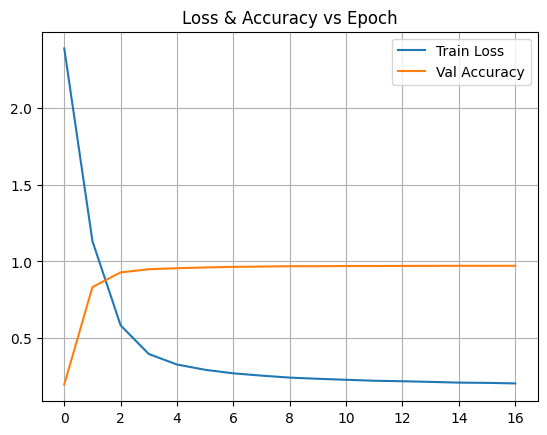

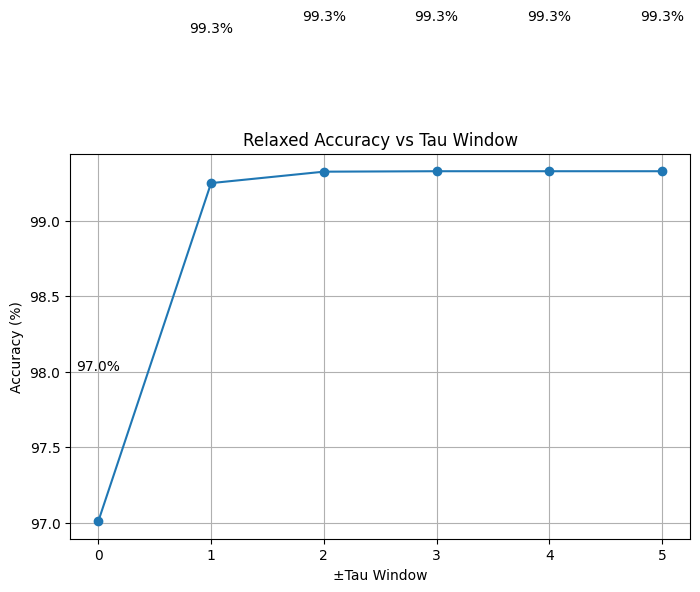

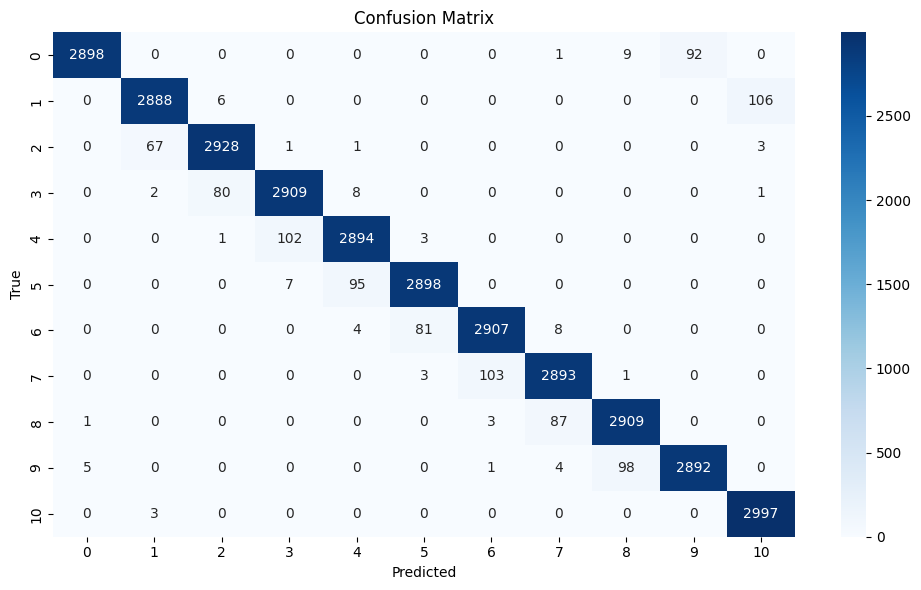

In [10]:
# ========== Configuration ==========
SEED = 0
T = 10
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 30000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1 = pd.read_csv("/kaggle/input/bsc-bch-codeword-length31/bsc_p0.001_codewords1.csv").values
csv2 = pd.read_csv("/kaggle/input/bsc-bch-codeword-length31/bsc_p0.001_codewords2.csv").values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
# X, y = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN + SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=SAMPLES_PER_CLASS_TEST * NUM_CLASSES, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval)
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)



# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ChangepointDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(ChangepointDataset(X_test, y_test), batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = 0
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


***T = 10, p = 0.001, CL = 31, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 9.7, 24.1, 38.5, 51.4, 62.9, 70.2
For N'(training samples/class) = 1500     Accuracy = 9.4, 24.4, 38.4, 53.4, 63.5, 73.0
For N'(training samples/class) = 2000     Accuracy = 90.0, 97.5, 97.6, 97.6, 97.6, 97.6
For N'(training samples/class) = 3000     Accuracy = 92.7, 98.3, 98.5, 98.6, 98.6, 98.6
For N'(training samples/class) = 4000     Accuracy = 93.4
For N'(training samples/class) = 5000     Accuracy = 94.6, 98.7, 98.8, 98.9, 98.9, 98.9 
For N'(training samples/class) = 6000     Accuracy = 95.5
For N'(training samples/class) = 7000     Accuracy = 95.1
For N'(training samples/class) = 8000     Accuracy = 95.8
For N'(training samples/class) = 9000     Accuracy = 96.1
For N'(training samples/class) = 10000     Accuracy = 96.2, 99.1, 99.2, 99.2, 99.2, 99,2
For N'(training samples/class) = 11000     Accuracy = 96.5
For N'(training samples/class) = 12000     Accuracy = 96.8
For N'(training samples/class) = 15000     Accuracy = 96.5
For N'(training samples/class) = 20000     Accuracy = 96.8
For N'(training samples/class) = 30000     Accuracy = 97.0, 99.3, 99.3, 99.3, 99.3, 99.3
</pre>

## p = 0.005

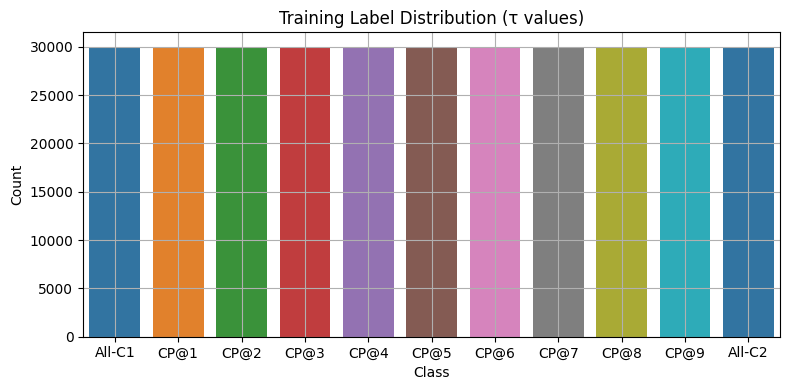

Training Epochs:   2%|▏         | 1/50 [00:30<24:59, 30.60s/it]

Epoch  1 | Train Loss: 2.3951 | Val Accuracy: 0.1676


Training Epochs:   4%|▍         | 2/50 [01:01<24:45, 30.96s/it]

Epoch  2 | Train Loss: 1.2419 | Val Accuracy: 0.7722


Training Epochs:   6%|▌         | 3/50 [01:32<24:02, 30.70s/it]

Epoch  3 | Train Loss: 0.6923 | Val Accuracy: 0.9025


Training Epochs:   8%|▊         | 4/50 [02:02<23:29, 30.65s/it]

Epoch  4 | Train Loss: 0.4808 | Val Accuracy: 0.9286


Training Epochs:  10%|█         | 5/50 [02:33<22:55, 30.57s/it]

Epoch  5 | Train Loss: 0.3844 | Val Accuracy: 0.9436


Training Epochs:  12%|█▏        | 6/50 [03:01<21:53, 29.86s/it]

Epoch  6 | Train Loss: 0.3308 | Val Accuracy: 0.9541


Training Epochs:  14%|█▍        | 7/50 [03:30<21:04, 29.41s/it]

Epoch  7 | Train Loss: 0.2939 | Val Accuracy: 0.9595


Training Epochs:  16%|█▌        | 8/50 [04:00<20:45, 29.66s/it]

Epoch  8 | Train Loss: 0.2715 | Val Accuracy: 0.9631


Training Epochs:  18%|█▊        | 9/50 [04:30<20:26, 29.91s/it]

Epoch  9 | Train Loss: 0.2544 | Val Accuracy: 0.9648


Training Epochs:  20%|██        | 10/50 [05:01<20:06, 30.15s/it]

Epoch 10 | Train Loss: 0.2441 | Val Accuracy: 0.9665


Training Epochs:  22%|██▏       | 11/50 [05:31<19:33, 30.10s/it]

Epoch 11 | Train Loss: 0.2346 | Val Accuracy: 0.9668


Training Epochs:  24%|██▍       | 12/50 [06:01<18:57, 29.93s/it]

Epoch 12 | Train Loss: 0.2264 | Val Accuracy: 0.9676


Training Epochs:  26%|██▌       | 13/50 [06:32<18:39, 30.26s/it]

Epoch 13 | Train Loss: 0.2218 | Val Accuracy: 0.9679


Training Epochs:  26%|██▌       | 13/50 [07:02<20:03, 32.52s/it]

Epoch 14 | Train Loss: 0.2166 | Val Accuracy: 0.9685
Early stopping triggered.



Final Test Accuracy: 0.9674



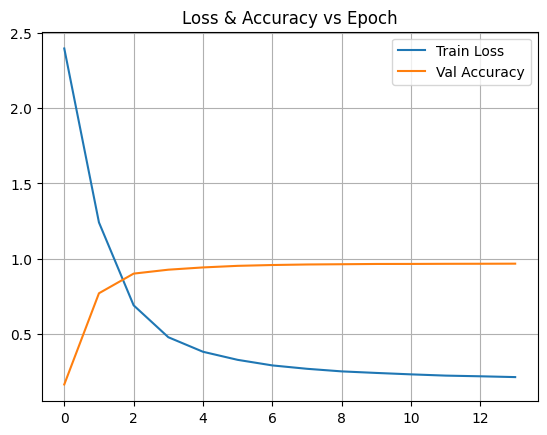

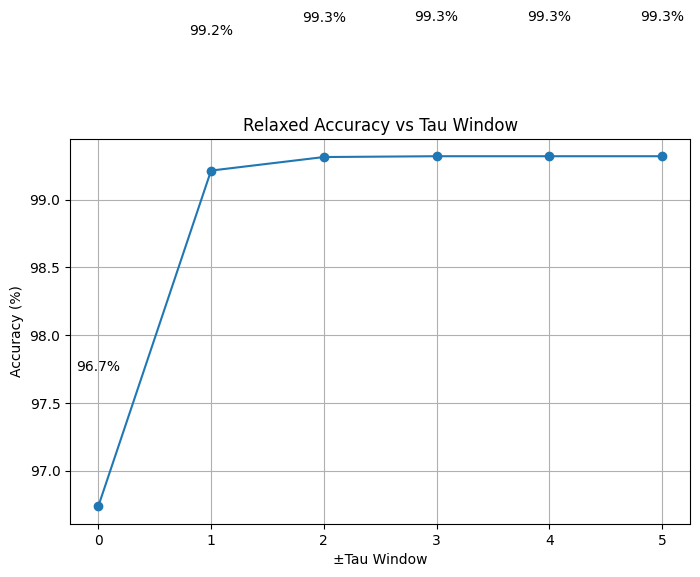

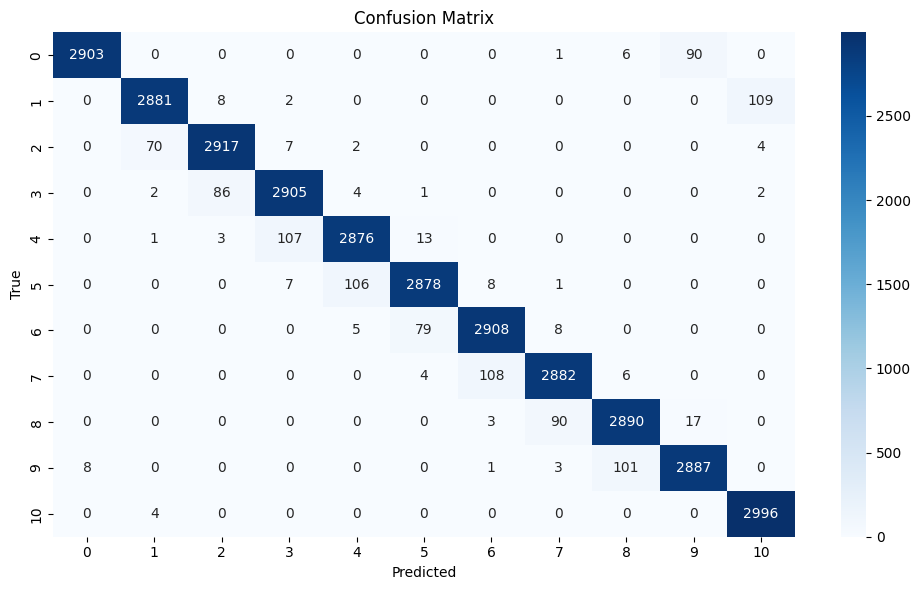

In [17]:
# ========== Configuration ==========
SEED = 0
T = 10
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 30000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1 = pd.read_csv("/kaggle/input/bsc-bch-codeword-length31/bsc_p0.005_codewords1.csv").values
csv2 = pd.read_csv("/kaggle/input/bsc-bch-codeword-length31/bsc_p0.005_codewords2.csv").values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
# X, y = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN + SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=SAMPLES_PER_CLASS_TEST * NUM_CLASSES, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval)
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)



# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ChangepointDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(ChangepointDataset(X_test, y_test), batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = 0
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


***T = 10, p = 0.005, CL = 31, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 10.1, 25.4, 40.6, 52.3, 62.2, 71.1
For N'(training samples/class) = 2000     Accuracy = 8.70, 25.5, 39.2, 51.8, 63.4, 72.6
For N'(training samples/class) = 2500     Accuracy = 9.10
For N'(training samples/class) = 3000     Accuracy = 88.7, 97.6, 97.9, 98.0, 98.0, 98.0
For N'(training samples/class) = 4000     Accuracy = 92.2, 98.0, 98.2, 98.2, 98.2, 98.2
For N'(training samples/class) = 5000     Accuracy = 93.5, 98.5, 98.8, 98.9, 98.9, 98.9
For N'(training samples/class) = 6000     Accuracy = 94.1
For N'(training samples/class) = 7000     Accuracy = 94.6
For N'(training samples/class) = 8000     Accuracy = 94.9
For N'(training samples/class) = 9000     Accuracy = 95.2
For N'(training samples/class) = 10000     Accuracy = 95.8, 98.9, 99.0, 99.0, 99.0, 99.0
For N'(training samples/class) = 11000     Accuracy = 95.7
For N'(training samples/class) = 12000     Accuracy = 95.6
For N'(training samples/class) = 15000     Accuracy = 96.1
For N'(training samples/class) = 20000     Accuracy = 95.9
For N'(training samples/class) = 30000     Accuracy = 96.7
For N'(training samples/class) = 40000     Accuracy = 96.9, 99.2, 99.3, 99.3, 99.3, 99.3 
</pre>

## p = 0.010

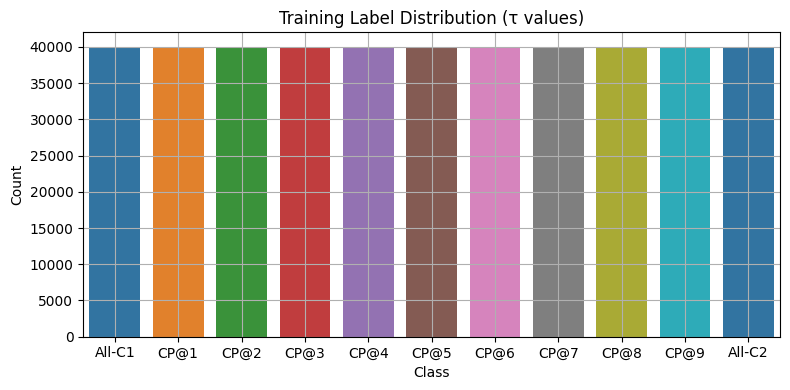

Training Epochs:   2%|▏         | 1/50 [00:40<33:26, 40.94s/it]

Epoch  1 | Train Loss: 2.3317 | Val Accuracy: 0.3723


Training Epochs:   4%|▍         | 2/50 [01:21<32:38, 40.81s/it]

Epoch  2 | Train Loss: 1.0830 | Val Accuracy: 0.8318


Training Epochs:   6%|▌         | 3/50 [02:02<31:56, 40.77s/it]

Epoch  3 | Train Loss: 0.6395 | Val Accuracy: 0.9117


Training Epochs:   8%|▊         | 4/50 [02:43<31:19, 40.87s/it]

Epoch  4 | Train Loss: 0.4624 | Val Accuracy: 0.9360


Training Epochs:  10%|█         | 5/50 [03:24<30:46, 41.04s/it]

Epoch  5 | Train Loss: 0.3804 | Val Accuracy: 0.9470


Training Epochs:  12%|█▏        | 6/50 [04:06<30:13, 41.21s/it]

Epoch  6 | Train Loss: 0.3330 | Val Accuracy: 0.9515


Training Epochs:  14%|█▍        | 7/50 [04:45<29:09, 40.68s/it]

Epoch  7 | Train Loss: 0.3062 | Val Accuracy: 0.9552


Training Epochs:  16%|█▌        | 8/50 [05:24<28:05, 40.13s/it]

Epoch  8 | Train Loss: 0.2855 | Val Accuracy: 0.9571


Training Epochs:  18%|█▊        | 9/50 [06:04<27:13, 39.84s/it]

Epoch  9 | Train Loss: 0.2709 | Val Accuracy: 0.9588


Training Epochs:  20%|██        | 10/50 [06:44<26:46, 40.16s/it]

Epoch 10 | Train Loss: 0.2609 | Val Accuracy: 0.9596


Training Epochs:  22%|██▏       | 11/50 [07:25<26:14, 40.37s/it]

Epoch 11 | Train Loss: 0.2524 | Val Accuracy: 0.9612


Training Epochs:  24%|██▍       | 12/50 [08:06<25:41, 40.57s/it]

Epoch 12 | Train Loss: 0.2428 | Val Accuracy: 0.9614


Training Epochs:  26%|██▌       | 13/50 [08:47<25:04, 40.66s/it]

Epoch 13 | Train Loss: 0.2344 | Val Accuracy: 0.9611


Training Epochs:  28%|██▊       | 14/50 [09:28<24:30, 40.85s/it]

Epoch 14 | Train Loss: 0.2250 | Val Accuracy: 0.9622


Training Epochs:  28%|██▊       | 14/50 [10:10<26:09, 43.61s/it]

Epoch 15 | Train Loss: 0.2162 | Val Accuracy: 0.9620
Early stopping triggered.



Final Test Accuracy: 0.9626



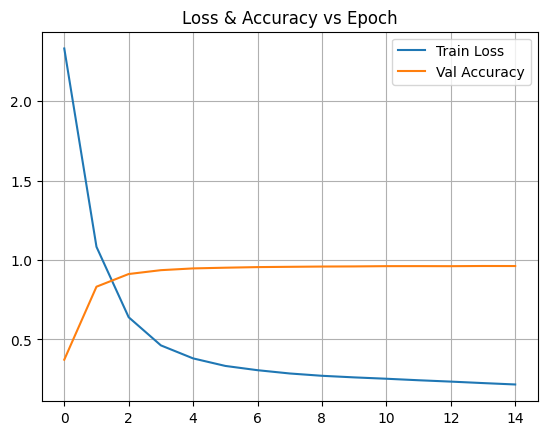

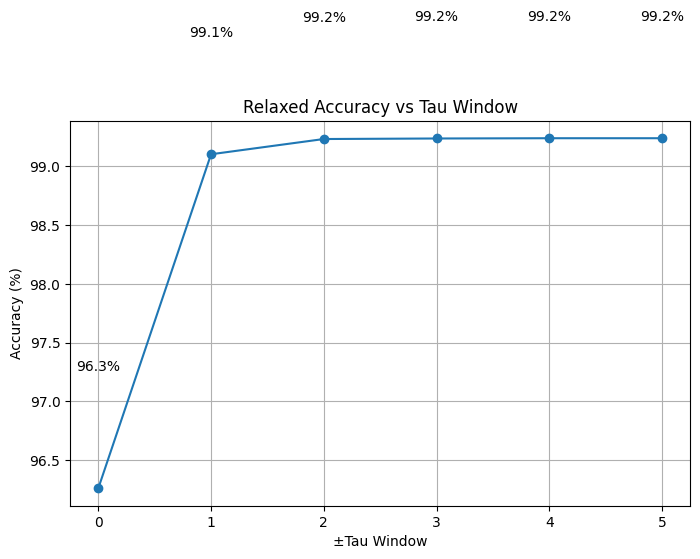

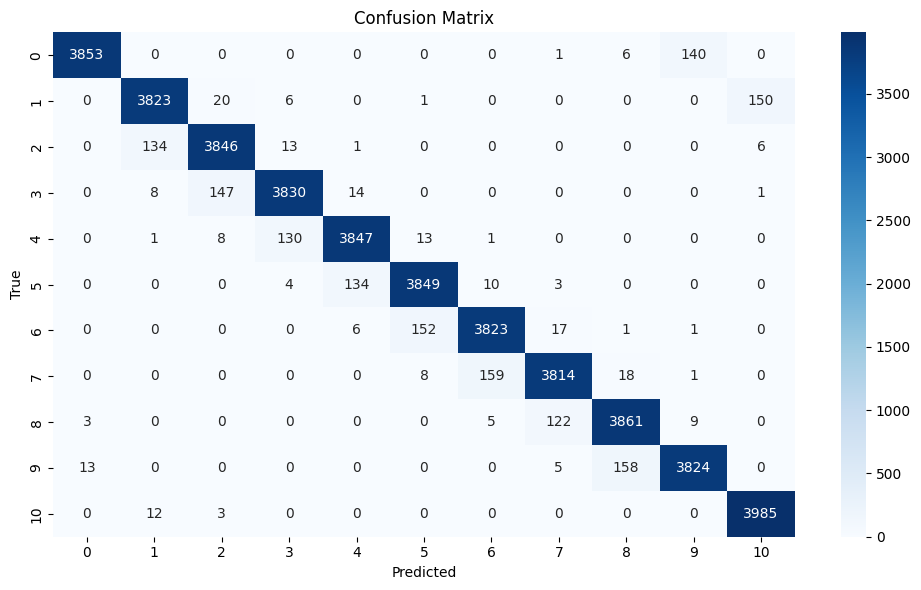

In [26]:
# ========== Configuration ==========
SEED = 0
T = 10
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 40000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1 = pd.read_csv("/kaggle/input/bsc-bch-codeword-length31/bsc_p0.010_codewords1.csv").values
csv2 = pd.read_csv("/kaggle/input/bsc-bch-codeword-length31/bsc_p0.010_codewords2.csv").values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
# X, y = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN + SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=SAMPLES_PER_CLASS_TEST * NUM_CLASSES, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval)
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)



# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ChangepointDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(ChangepointDataset(X_test, y_test), batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = 0
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


***T = 10, p = 0.010, CL = 31, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 9.2, 62.5, 75.5, 79.4, 80.5, 80.5
For N'(training samples/class) = 2000     Accuracy = 9.5
For N'(training samples/class) = 3000     Accuracy = 86.9, 96.3, 97.1, 97.2, 97.2, 97.2
For N'(training samples/class) = 4000     Accuracy = 90.9, 97.5, 97.9, 98.0, 98.0, 98.0
For N'(training samples/class) = 5000     Accuracy = 93.2, 98.2, 98.6, 98.6, 98.6, 98.6
For N'(training samples/class) = 6000     Accuracy = 93.5
For N'(training samples/class) = 7000     Accuracy = 93.9
For N'(training samples/class) = 8000     Accuracy = 94.4
For N'(training samples/class) = 9000     Accuracy = 94.7
For N'(training samples/class) = 10000     Accuracy = 95.0, 98.6, 98.9, 98.9, 98.9, 98.9 
For N'(training samples/class) = 11000     Accuracy = 95.2
For N'(training samples/class) = 12000     Accuracy = 95.1
For N'(training samples/class) = 15000     Accuracy = 95.3
For N'(training samples/class) = 20000     Accuracy = 95.6
For N'(training samples/class) = 30000     Accuracy = 95.9
For N'(training samples/class) = 40000     Accuracy = 96.3, 99.1, 99.2, 99.2, 99.2, 99.2
For N'(training samples/class) = 50000     Accuracy = 96.3
</pre>

## p = 0.050

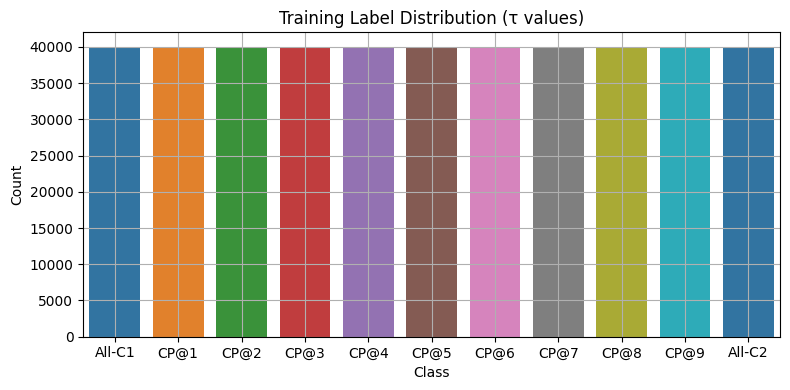

Training Epochs:   2%|▏         | 1/50 [00:40<33:22, 40.87s/it]

Epoch  1 | Train Loss: 2.3993 | Val Accuracy: 0.0956


Training Epochs:   4%|▍         | 2/50 [01:20<32:17, 40.37s/it]

Epoch  2 | Train Loss: 2.0158 | Val Accuracy: 0.4837


Training Epochs:   6%|▌         | 3/50 [02:01<31:32, 40.27s/it]

Epoch  3 | Train Loss: 1.2049 | Val Accuracy: 0.6764


Training Epochs:   8%|▊         | 4/50 [02:40<30:32, 39.83s/it]

Epoch  4 | Train Loss: 0.9676 | Val Accuracy: 0.7874


Training Epochs:  10%|█         | 5/50 [03:19<29:39, 39.55s/it]

Epoch  5 | Train Loss: 0.8119 | Val Accuracy: 0.8342


Training Epochs:  12%|█▏        | 6/50 [04:00<29:23, 40.07s/it]

Epoch  6 | Train Loss: 0.7075 | Val Accuracy: 0.8584


Training Epochs:  14%|█▍        | 7/50 [04:40<28:50, 40.24s/it]

Epoch  7 | Train Loss: 0.6385 | Val Accuracy: 0.8718


Training Epochs:  16%|█▌        | 8/50 [05:21<28:19, 40.46s/it]

Epoch  8 | Train Loss: 0.5905 | Val Accuracy: 0.8811


Training Epochs:  18%|█▊        | 9/50 [06:02<27:43, 40.56s/it]

Epoch  9 | Train Loss: 0.5539 | Val Accuracy: 0.8867


Training Epochs:  20%|██        | 10/50 [06:42<26:59, 40.48s/it]

Epoch 10 | Train Loss: 0.5280 | Val Accuracy: 0.8928


Training Epochs:  22%|██▏       | 11/50 [07:23<26:20, 40.53s/it]

Epoch 11 | Train Loss: 0.5031 | Val Accuracy: 0.8962


Training Epochs:  24%|██▍       | 12/50 [08:04<25:44, 40.63s/it]

Epoch 12 | Train Loss: 0.4844 | Val Accuracy: 0.8991


Training Epochs:  26%|██▌       | 13/50 [08:45<25:11, 40.85s/it]

Epoch 13 | Train Loss: 0.4647 | Val Accuracy: 0.9034


Training Epochs:  28%|██▊       | 14/50 [09:26<24:30, 40.86s/it]

Epoch 14 | Train Loss: 0.4476 | Val Accuracy: 0.9076


Training Epochs:  30%|███       | 15/50 [10:07<23:50, 40.87s/it]

Epoch 15 | Train Loss: 0.4335 | Val Accuracy: 0.9096


Training Epochs:  32%|███▏      | 16/50 [10:48<23:09, 40.86s/it]

Epoch 16 | Train Loss: 0.4167 | Val Accuracy: 0.9105


Training Epochs:  34%|███▍      | 17/50 [11:29<22:27, 40.83s/it]

Epoch 17 | Train Loss: 0.4023 | Val Accuracy: 0.9140


Training Epochs:  36%|███▌      | 18/50 [12:09<21:45, 40.81s/it]

Epoch 18 | Train Loss: 0.3910 | Val Accuracy: 0.9152


Training Epochs:  38%|███▊      | 19/50 [12:50<21:03, 40.77s/it]

Epoch 19 | Train Loss: 0.3778 | Val Accuracy: 0.9184


Training Epochs:  40%|████      | 20/50 [13:31<20:21, 40.72s/it]

Epoch 20 | Train Loss: 0.3665 | Val Accuracy: 0.9200


Training Epochs:  42%|████▏     | 21/50 [14:12<19:43, 40.80s/it]

Epoch 21 | Train Loss: 0.3560 | Val Accuracy: 0.9224


Training Epochs:  44%|████▍     | 22/50 [14:53<19:09, 41.06s/it]

Epoch 22 | Train Loss: 0.3454 | Val Accuracy: 0.9241


Training Epochs:  46%|████▌     | 23/50 [15:34<18:28, 41.05s/it]

Epoch 23 | Train Loss: 0.3369 | Val Accuracy: 0.9244


Training Epochs:  48%|████▊     | 24/50 [16:15<17:45, 40.96s/it]

Epoch 24 | Train Loss: 0.3309 | Val Accuracy: 0.9255


Training Epochs:  50%|█████     | 25/50 [16:56<17:03, 40.94s/it]

Epoch 25 | Train Loss: 0.3212 | Val Accuracy: 0.9272


Training Epochs:  52%|█████▏    | 26/50 [17:37<16:22, 40.93s/it]

Epoch 26 | Train Loss: 0.3151 | Val Accuracy: 0.9284


Training Epochs:  54%|█████▍    | 27/50 [18:18<15:40, 40.90s/it]

Epoch 27 | Train Loss: 0.3085 | Val Accuracy: 0.9284


Training Epochs:  56%|█████▌    | 28/50 [18:58<14:54, 40.67s/it]

Epoch 28 | Train Loss: 0.3054 | Val Accuracy: 0.9301


Training Epochs:  58%|█████▊    | 29/50 [19:36<13:58, 39.95s/it]

Epoch 29 | Train Loss: 0.2997 | Val Accuracy: 0.9309


Training Epochs:  60%|██████    | 30/50 [20:17<13:24, 40.22s/it]

Epoch 30 | Train Loss: 0.2952 | Val Accuracy: 0.9315


Training Epochs:  62%|██████▏   | 31/50 [20:58<12:47, 40.41s/it]

Epoch 31 | Train Loss: 0.2917 | Val Accuracy: 0.9305


Training Epochs:  64%|██████▍   | 32/50 [21:39<12:08, 40.49s/it]

Epoch 32 | Train Loss: 0.2866 | Val Accuracy: 0.9318


Training Epochs:  64%|██████▍   | 32/50 [22:19<12:33, 41.87s/it]

Epoch 33 | Train Loss: 0.2838 | Val Accuracy: 0.9328
Early stopping triggered.



Final Test Accuracy: 0.9340



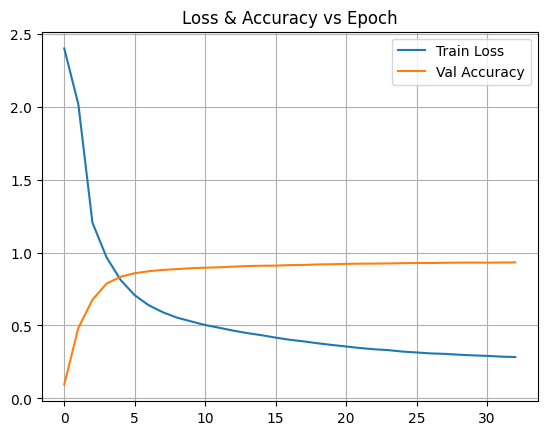

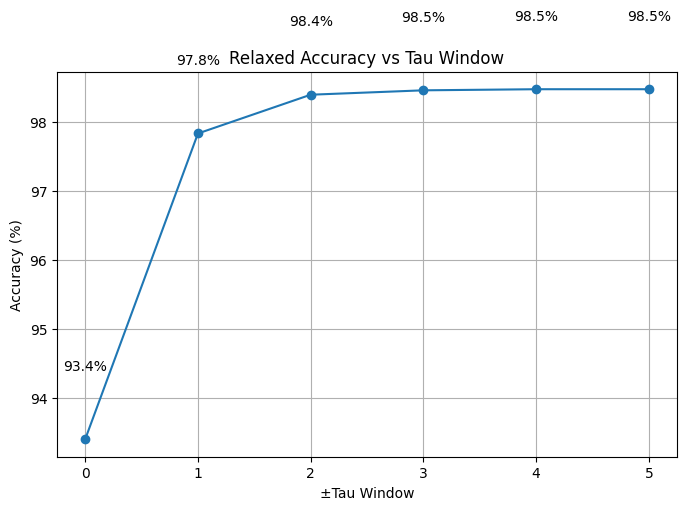

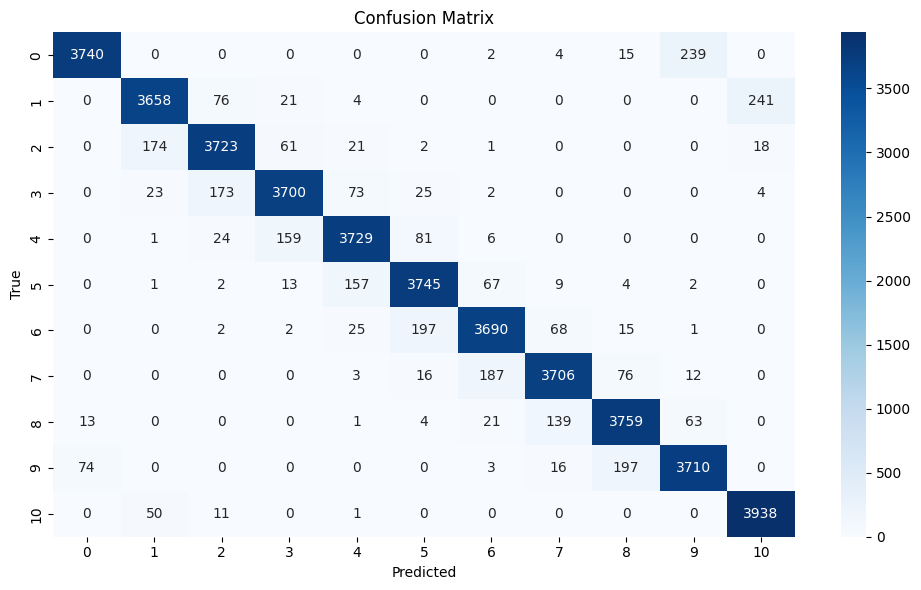

In [35]:
# ========== Configuration ==========
SEED = 0
T = 10
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 40000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1 = pd.read_csv("/kaggle/input/bsc-bch-codeword-length31/bsc_p0.050_codewords1.csv").values
csv2 = pd.read_csv("/kaggle/input/bsc-bch-codeword-length31/bsc_p0.050_codewords2.csv").values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
# X, y = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN + SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=SAMPLES_PER_CLASS_TEST * NUM_CLASSES, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval)
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)



# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ChangepointDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(ChangepointDataset(X_test, y_test), batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = 0
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


***T = 10, p = 0.050, CL = 31, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 8.2, 21.7, 35.9, 48.8, 60.1, 70.5
For N'(training samples/class) = 2000     Accuracy = 9.1, 25.5, 39.1, 52.1 63.5, 72.5
For N'(training samples/class) = 3000     Accuracy = 64.1, 87.3, 90.5, 91.3, 91.6, 91.7
For N'(training samples/class) = 4000     Accuracy = 75.1, 92.4, 94.1, 94.5, 94.7, 94.7 
For N'(training samples/class) = 5000     Accuracy = 81.5, 94.5, 95.7, 95.8, 95.9, 95.9
For N'(training samples/class) = 6000     Accuracy = 83.8
For N'(training samples/class) = 7000     Accuracy = 86.1
For N'(training samples/class) = 8000     Accuracy = 87.8, 96.2, 97.0, 97.2, 97.2, 97.2
For N'(training samples/class) = 9000     Accuracy = 88.9
For N'(training samples/class) = 10000     Accuracy = 90.0, 96.8, 97.5, 97.7, 97.7, 97.7
For N'(training samples/class) = 11000     Accuracy = 90.2
For N'(training samples/class) = 12000     Accuracy = 90.8
For N'(training samples/class) = 15000     Accuracy = 91.5
For N'(training samples/class) = 20000     Accuracy = 91.6
For N'(training samples/class) = 30000     Accuracy = 92.7
For N'(training samples/class) = 40000     Accuracy = 93.4
</pre>